Nous allons utiliser ce code pour comprendre le fonctionnement des utilsateur du vélo à Paris. Pour cela nous allons utiliser des résultats assez symle qui sont des moyens par heure, jour, mois. Ainsi qu'une analyse géographiques. 

# Importation

Nous commençons par importer les bibliothèques dont nous aurons besoin pour ce projet.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd


Nous modifions nos csv en dataframe pour pouvoir travailler dessus.

In [2]:
df = pd.read_csv("comptage-velo-donnees-compteurs-annee.csv", sep=";")

Nous allons maintenant procéder au nettoyage des données.

# Nettoyage

Nous commençons par sélectionner les colonnes qui nous intéressent.

In [3]:
df = df[[
    "Date et heure de comptage",
    "Identifiant du site de comptage",
    "Identifiant du compteur",
    "Nom du site de comptage",
    "Comptage horaire",
    "Coordonnées géographiques"
]]

Nous supprimons les lignes incomplètes

In [4]:
df = df.dropna()

Une analyse rapide a permis de détecter des capteurs enregistrant constamment 0 vélo.  
On suppose qu'ils sont défectueux et nous allons donc les supprimer.

In [5]:
defecteux = df.groupby("Identifiant du site de comptage").agg(
    Moyenne_velo=("Comptage horaire", "mean")
).reset_index()
sites_defectueux = defecteux[defecteux["Moyenne_velo"] == 0]["Identifiant du site de comptage"].tolist()
df = df[~df["Identifiant du site de comptage"].isin(sites_defectueux)]

Nous souhaitons travailler sur des adresses propres, c'est-à-dire en conservant uniquement le type de voie et le nom de l'adresse.

In [6]:
df["Nom du site de comptage"] = (
    df["Nom du site de comptage"]
    .str.replace(r"^(Face\s*au\s*\d+\s*)", "", regex=True)
    .str.replace(r"^(Totem\s*\d+\s*)", "", regex=True)
    .str.replace(r"^\d+\s*", "", regex=True)
    .str.strip()
)

Nous allons maintenant nettoyer les heures.  
Pour cela, nous supprimons les informations de fuseau horaire afin de gérer correctement l'heure d'hiver et l'heure d'été.

In [7]:
df["Date et heure de comptage"] = pd.to_datetime(df["Date et heure de comptage"], errors="coerce", utc=True)
df["Date et heure de comptage"] = df["Date et heure de comptage"].dt.tz_convert(None)


Ensuite, nous allons créer les variables heures, jours et mois à partir de ces données.

Nous allons utiliser jour_num et mois_num pour pouvoir trier dans l'ordre de la semaine et des mois.

Pour la variable heures, nous ajoutons 1, car Paris se situe en UTC+1.

    

In [33]:
df["Heure"] = df["Date et heure de comptage"].dt.hour + 1
df["Jour_num"] = df["Date et heure de comptage"].dt.dayofweek
df["Mois_num"] = df["Date et heure de comptage"].dt.month

Nous utiliserons plus tard ses listes pour avoir les noms des jours et des mois en français.

In [43]:
jours_fr = {
    0: "Lundi", 1: "Mardi", 2: "Mercredi",
    3: "Jeudi", 4: "Vendredi", 5: "Samedi", 6: "Dimanche"
}

mois_fr = {
    1: "Janvier",2: "Février",3: "Mars",4: "Avril",
    5: "Mai",6: "Juin",7: "Juillet",8: "Août",
    9: "Septembre",10: "Octobre",11: "Novembre",12: "Décembre"
}

Pour calculer la moyenne par mois, il est nécessaire de normaliser les données en fonction du nombre de jours de chaque mois.

In [11]:
jours_par_mois = (
    df.groupby("Mois_num")["Date et heure de comptage"]
      .apply(lambda x: x.dt.date.nunique())
      .reset_index(name="Nb_jours")
)

Nous souhaitons également récupérer les données de latitude et de longitude des capteurs afin de pouvoir les placer sur une carte ensuite.

In [10]:
df[["lat", "lon"]] = df["Coordonnées géographiques"].str.split(",", expand=True).astype(float)

Enfin, nous effectuons des vérifications pour nous assurer qu'il n'y a ni doublons, ni valeurs NaN dans nos données.

In [12]:
print("Nombre de doublons :", df.duplicated().sum())
print("Valeurs manquantes restantes :")
print(df.isnull().sum())

Nombre de doublons : 0
Valeurs manquantes restantes :
Date et heure de comptage          0
Identifiant du site de comptage    0
Identifiant du compteur            0
Nom du site de comptage            0
Comptage horaire                   0
Coordonnées géographiques          0
Heure                              0
Jour                               0
Jour_num                           0
Mois                               0
Mois_num                           0
lat                                0
lon                                0
dtype: int64


Nous avons terminé la mise en place des variables et pouvons maintenant passer à l'analyse. 

# Analyse

Pour commencer, nous allons calculer les moyennes journalières par heure.  
Pour ce faire, nous divisons les données par 365 (nombre de jours dans l'année).

In [13]:
moyenne_heure = (
    (df.groupby("Heure")["Comptage horaire"].sum() / 365)
    .reset_index().round(1)
    .sort_values(by="Heure")
)

Nous procédons de la même manière pour calculer la moyenne par jour (52 = nombre de semaines dans l'année).

In [29]:
moyenne_jour = (
    (df.groupby("Jour_num")["Comptage horaire"].sum() / 52)
    .reset_index().round(1)
    .sort_values(by="Jour_num", ascending=True)
)

Nous appliquons maintenant la liste plus haut pour avoir nos noms en français

In [ ]:
moyenne_jour["Jour"] = moyenne_jour["Jour_num"].map(jours_fr)

Pour les mois, la situation est un peu plus complexe, car nous devons normaliser les données en fonction du nombre de jours de chaque mois.

In [44]:
somme_mois = df.groupby("Mois_num")["Comptage horaire"].sum().reset_index(name="Total_velos")
moyenne_mois = somme_mois.merge(jours_par_mois, on="Mois_num")
moyenne_mois["Moyenne_jour"] = (moyenne_mois["Total_velos"] / moyenne_mois["Nb_jours"]).round(1)

Nous faisons comme pour les jours afin d'obtenir un résultat en français.

In [45]:
moyenne_mois["Mois"] = moyenne_mois["Mois_num"].map(mois_fr)

Nous allons ici calculer quelques KPI et effectuer des calculs qui nous serviront ensuite pour la création des graphiques.

In [ ]:
# Pic du matin et du soir
pic_matin = moyenne_heure.idxmax() if moyenne_heure.index[0] < 12 else "Non défini"
pic_soir = moyenne_heure.idxmax() if moyenne_heure.index[0] >= 12 else "Non défini"

# Jours avec le plus et le moins de trafic
moyenne_annee = df.groupby("Jour")["Comptage horaire"].sum() / 365
jour_max = moyenne_annee.idxmax()
jour_min = moyenne_annee.idxmin()

# Mois avec le plus et le moins de trafic
mois_max = moyenne_mois.loc[moyenne_mois["Moyenne_jour"].idxmax(), "Mois"]
mois_min = moyenne_mois.loc[moyenne_mois["Moyenne_jour"].idxmin(), "Mois"]

# Trafic moyen journalier
trafic_moyen = int(df["Comptage horaire"].sum() / 365)

Nous pouvons maintenant passer à la visualisation des données.

# Visualisation

Commençons par afficher les graphiques des moyennes journalières selon l'heure.

In [ ]:
fig3 = px.line(
    moyenne_heure, 
    x="Heure", 
    y="Comptage horaire", 
    title="Moyenne des vélos par heure",
    markers=True
)
fig3.update_traces(line_color="#48628c", line_width=3.5)

fig3.update_xaxes(
    tickmode="linear",
    dtick=1,   # 1 = un tick par unité
    tick0=1    # commence à 1
)

fig3.update_layout(
    template="plotly",
    title_x=0.5,
    xaxis_title="Heure de la journée",
    yaxis_title="Nombre moyen de vélos"
)
fig3.show()





Ensuite, nous affichons les graphiques des moyennes journalières selon le jour de la semaine.

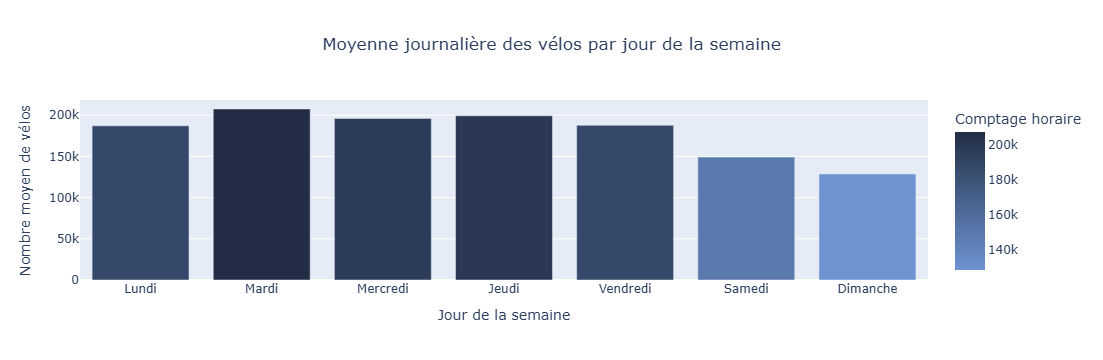

In [30]:
fig4 = px.bar(
    moyenne_jour, 
    x="Jour", 
    y="Comptage horaire", 
    title="Moyenne journalière des vélos par jour de la semaine", 
    color="Comptage horaire",
    color_continuous_scale=[
        (0, "#6d93d1"),   
        (0.5, "#48628c"), 
        (1, "#222d45")    
    ]
)
fig4.update_layout(
    template="plotly",
    title_x=0.5,
    xaxis_title="Jour de la semaine",
    yaxis_title="Nombre moyen de vélos"
)

fig4.show()




Nous passons ensuite aux graphiques des moyennes journalières selon les mois de l'année.

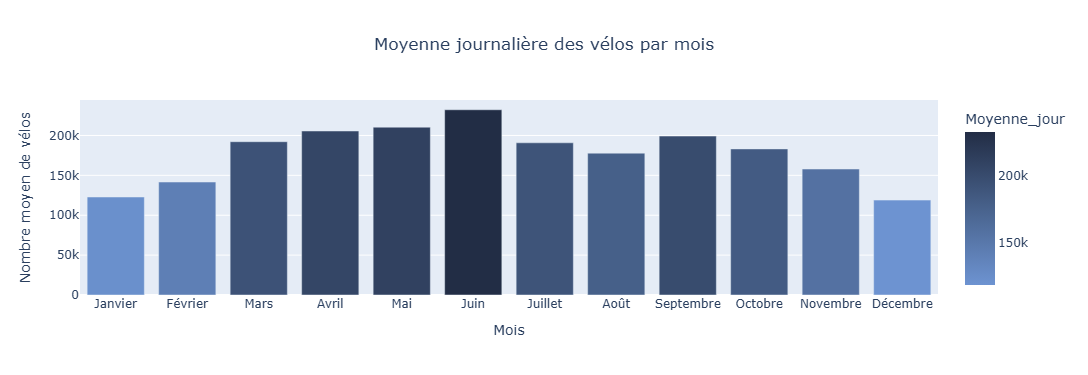

In [46]:
fig5 = px.bar(
    moyenne_mois, 
    x="Mois", 
    y="Moyenne_jour", 
    title="Moyenne journalière des vélos par mois", 
    color="Moyenne_jour",
    color_continuous_scale=[
        (0, "#6d93d1"),   
        (0.5, "#48628c"), 
        (1, "#222d45")    
    ]
)
fig5.update_layout(
    template="plotly",
    title_x=0.5,
    xaxis_title="Mois",
    yaxis_title="Nombre moyen de vélos"
)

fig5.show()






Enfin, nous terminons par une carte représentant la moyenne du nombre de vélos passant devant les capteurs à 17h.

In [ ]:
int_heure = df.groupby(["Nom du site de comptage", "lat", "lon", "Heure"]).agg(
    Velos=("Comptage horaire", "sum")
).reset_index()

int_17h = int_heure[int_heure["Heure"] == 17]

vmin = int_17h["Velos"].min()
vmax = int_17h["Velos"].max()

fig = px.scatter_map(
    int_17h,
    lat="lat",
    lon="lon",
    size="Velos",
    color="Velos",
    hover_name="Nom du site de comptage",
    size_max=35,
    color_continuous_scale="Viridis",
    range_color=[vmin, vmax],
    zoom=12,
    map_style="carto-positron"  
)

fig.update_traces(
    marker=dict(
        opacity=0.7,  
        sizemode="area"
    )
)

fig.update_layout(
    width=700,
    height=700,
    title="Trafic cycliste à Paris - 17h",
    title_x=0.5,  # centrer le titre
    margin=dict(l=20, r=20, t=50, b=20),
    coloraxis_colorbar=dict(title="Nombre de vélos"),
    map=dict(center={"lat": 48.8566, "lon": 2.3441}, zoom=10.8)  # centrage sur Paris
)

fig.show()